References:
1. [Topic Modelling & LDA](https://www.baeldung.com/cs/latent-dirichlet-allocation)
2. [Coherence Score](https://www.baeldung.com/cs/topic-modeling-coherence-score)
3. [NMF for Topic Modelling Tutorial](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45) 

# **Imports**

In [1]:
!pip install imgaug==0.2.5 --quiet
!pip install gensim==4.2.0 --quiet
!pip install bertopic --quiet
!pip install -U "tmtoolkit[recommended,sklearn]" --quiet

     |████████████████████████████████| 562 kB 4.5 MB/s 
     |████████████████████████████████| 24.1 MB 1.7 MB/s 
     |████████████████████████████████| 76 kB 2.4 MB/s 
     |████████████████████████████████| 88 kB 6.1 MB/s 
     |████████████████████████████████| 5.2 MB 42.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 85 kB 4.5 MB/s 
     |████████████████████████████████| 636 kB 26.7 MB/s 
     |████████████████████████████████| 4.7 MB 41.5 MB/s 
     |████████████████████████████████| 1.3 MB 61.2 MB/s 
     |████████████████████████████████| 120 kB 48.0 MB/s 
     |████████████████████████████████| 6.6 MB 43.8 MB/s 
     |████████████████████████████████| 1.1 MB 35.6 MB/s 
     |████████████████████████████████| 7.1 MB 3.7 MB/s 
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 25.9 MB 1.2 MB/s 
     |████████

In [2]:
!pip install pyldavis --quiet

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.3 MB 27.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tmtoolkit 0.10.0 requires pandas<1.2,>=1.1.0, but you have pandas 1.3.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.5.4 which is incompatible.


In [3]:
!pip install matplotlib_inline --quiet

In [1]:
# General
import pandas as pd
import numpy as np
import sklearn
import pickle

# Text preprocessing
from nltk.corpus import treebank
import nltk 
import string
import re

# Gensim Models
import gensim
from gensim.models import ldamulticore, ldamodel
from gensim.models import nmf
from gensim.models import Word2Vec, FastText

# bertopic
import bertopic

# image
from PIL import Image

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# enable execution in notebook
pyLDAvis.enable_notebook()

# Plotting
import matplotlib.pyplot as plt
import seaborn as sb

sb.set_style('darkgrid')
%matplotlib inline

# save img in svg format
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# google 
from google.colab import drive
drive.mount("/content/gdrive")

# Display data frame as a table
from google.colab import data_table
#data_table.enable_dataframe_formatter()

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# metrics dict
metrics = {}

# pretty print
from pprint import pprint

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


Mounted at /content/gdrive


# **1) Importing dataset**
To do:

1. Convert missing abstract fields to None.
2. Remove punctuation.
3. Lowercase everything

In [2]:
path = "/content/gdrive/MyDrive/experiments/topic_modelling/cleaned_data_aggressive.csv"

df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        2225 non-null   object
 1   Heading         2225 non-null   object
 2   Article         2225 non-null   object
 3   text_processed  2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [3]:
# split up sentences into tokens
def sent_2_tokens(sentences: list):
  for sentence in sentences:
    yield sentence.split(' ')

# list of sentences
data = list(df["text_processed"])
data_words = list(sent_2_tokens(data))

print(data_words[2][:10])

['troublehit', 'mitsubishi', 'motors', 'talk', 'french', 'carmaker', 'psa', 'peugeot', 'citroen', 'possible']


# **2) Embedding**

## **I. BOW Model**

In [4]:
# Create a mapping of unique integer (id) to word
id2word = gensim.corpora.Dictionary(data_words)

id2word.filter_extremes(no_below = 3,
                        no_above = 0.85,
                        keep_n = 5000)
id2word.compactify()

texts = data_words

# Create a corpus where each word is represented by a tuple of token id & token count
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[3][:5], "\n", data_words[3][:5])

[(29, 1), (34, 1), (49, 2), (89, 1), (93, 1)] 
 ['bmw', 'prepare', 'enter', 'market', 'carstyle']


## **II. TF-IDF Corpus**

In [5]:
from gensim.models.tfidfmodel import TfidfModel

model = TfidfModel(corpus = corpus,
                   id2word = id2word,)

# TF IDF corpus
tfidf_corpus = [model[x] for x in corpus]

# **3) LDA Model**

## **I. BOW**

In [6]:
# Training the lda model on bow representation
from gensim.models import ldamulticore

num_topics = 5

lda_model = ldamulticore.LdaMulticore(corpus = corpus,
                         id2word = id2word,
                         num_topics = num_topics,
                         passes = 5)

pprint(lda_model.print_topics())

[(0,
  '0.007*"could" + 0.007*"year" + 0.005*"make" + 0.005*"world" + '
  '0.005*"company" + 0.005*"game" + 0.005*"government" + 0.005*"technology" + '
  '0.005*"one" + 0.004*"use"'),
 (1,
  '0.013*"user" + 0.011*"use" + 0.011*"net" + 0.010*"site" + 0.010*"search" + '
  '0.008*"software" + 0.007*"service" + 0.007*"information" + 0.006*"one" + '
  '0.006*"security"'),
 (2,
  '0.017*"game" + 0.007*"year" + 0.006*"get" + 0.006*"play" + 0.006*"good" + '
  '0.006*"make" + 0.006*"time" + 0.006*"take" + 0.005*"win" + 0.005*"first"'),
 (3,
  '0.013*"technology" + 0.009*"mobile" + 0.009*"music" + 0.008*"new" + '
  '0.008*"consumer" + 0.007*"use" + 0.007*"digital" + 0.007*"year" + '
  '0.006*"video" + 0.006*"show"'),
 (4,
  '0.014*"use" + 0.012*"phone" + 0.010*"mobile" + 0.009*"make" + 0.007*"could" '
  '+ 0.006*"email" + 0.006*"take" + 0.006*"get" + 0.006*"work" + 0.005*"new"')]


## **II. TF-IDF**

In [7]:
# Training the lda model on the TF IDF Corpus
lda_tfidf = ldamulticore.LdaMulticore(corpus = tfidf_corpus,
                         id2word = id2word,
                         num_topics = num_topics,
                         passes = 5)

pprint(lda_tfidf.print_topics())

[(0,
  '0.005*"game" + 0.004*"technology" + 0.004*"device" + 0.004*"console" + '
  '0.004*"music" + 0.003*"nintendo" + 0.003*"sony" + 0.003*"consumer" + '
  '0.003*"gadget" + 0.003*"portable"'),
 (1,
  '0.004*"program" + 0.003*"film" + 0.003*"user" + 0.003*"software" + '
  '0.003*"domain" + 0.003*"net" + 0.003*"microsoft" + 0.002*"use" + '
  '0.002*"service" + 0.002*"virus"'),
 (2,
  '0.007*"search" + 0.005*"user" + 0.005*"spam" + 0.004*"computer" + '
  '0.004*"site" + 0.004*"net" + 0.004*"software" + 0.004*"use" + 0.004*"email" '
  '+ 0.003*"information"'),
 (3,
  '0.003*"blog" + 0.002*"game" + 0.002*"attack" + 0.002*"technology" + '
  '0.002*"patent" + 0.002*"site" + 0.002*"pc" + 0.002*"win" + 0.002*"user" + '
  '0.002*"england"'),
 (4,
  '0.008*"mobile" + 0.006*"phone" + 0.004*"computer" + 0.003*"camera" + '
  '0.003*"game" + 0.003*"technology" + 0.003*"music" + 0.003*"digital" + '
  '0.003*"pc" + 0.003*"tv"')]


# **4) Gensim NMF Model**

## **I. BOW**

In [8]:
# Training the lda model
from gensim.models import nmf

nmf_model = nmf.Nmf(corpus = corpus,
                    id2word = id2word,
                    num_topics = num_topics,
                    passes = 5,              
                    normalize = True,
                    random_state = 42,)

pprint(nmf_model.print_topics())

[(0,
  '0.013*"use" + 0.010*"mobile" + 0.009*"phone" + 0.009*"technology" + '
  '0.008*"service" + 0.007*"year" + 0.007*"make" + 0.006*"user" + 0.006*"firm" '
  '+ 0.006*"new"'),
 (1,
  '0.013*"party" + 0.010*"labour" + 0.009*"election" + 0.009*"government" + '
  '0.008*"minister" + 0.008*"blair" + 0.007*"wage" + 0.007*"pay" + '
  '0.007*"increase" + 0.006*"tory"'),
 (2,
  '0.013*"government" + 0.007*"could" + 0.006*"bn" + 0.006*"one" + 0.006*"us" '
  '+ 0.006*"year" + 0.005*"right" + 0.005*"new" + 0.005*"terrorist" + '
  '0.005*"country"'),
 (3,
  '0.034*"game" + 0.016*"music" + 0.015*"play" + 0.010*"player" + 0.008*"time" '
  '+ 0.008*"get" + 0.008*"make" + 0.007*"win" + 0.007*"go" + 0.006*"well"'),
 (4,
  '0.021*"good" + 0.017*"year" + 0.012*"win" + 0.012*"song" + 0.009*"film" + '
  '0.009*"last" + 0.008*"award" + 0.006*"think" + 0.005*"go" + '
  '0.005*"british"')]


## **II. TF-IDF**

In [9]:
# TF IDF transformed text
from gensim.models import nmf
nmf_tfidf = nmf.Nmf(corpus = tfidf_corpus,
                    id2word = id2word,
                    num_topics = num_topics,
                    passes = 5,              
                    normalize = True,
                    random_state = 42,
                )

pprint(nmf_tfidf.print_topics())

[(0,
  '0.008*"mobile" + 0.007*"phone" + 0.006*"technology" + 0.005*"user" + '
  '0.005*"service" + 0.005*"use" + 0.004*"digital" + 0.004*"broadband" + '
  '0.004*"network" + 0.004*"software"'),
 (1,
  '0.013*"film" + 0.009*"award" + 0.006*"star" + 0.005*"band" + 0.005*"album" '
  '+ 0.005*"oscar" + 0.005*"actor" + 0.005*"chart" + 0.005*"good" + '
  '0.004*"nomination"'),
 (2,
  '0.006*"bn" + 0.006*"bank" + 0.005*"economy" + 0.005*"growth" + 0.005*"oil" '
  '+ 0.005*"rate" + 0.005*"price" + 0.005*"rise" + 0.004*"yukos" + '
  '0.004*"economic"'),
 (3,
  '0.010*"game" + 0.006*"play" + 0.006*"win" + 0.005*"player" + '
  '0.005*"england" + 0.004*"match" + 0.004*"team" + 0.004*"cup" + '
  '0.003*"injury" + 0.003*"title"'),
 (4,
  '0.010*"labour" + 0.010*"election" + 0.008*"blair" + 0.008*"brown" + '
  '0.007*"party" + 0.007*"tory" + 0.006*"tax" + 0.005*"chancellor" + '
  '0.005*"minister" + 0.005*"howard"')]


# **5) Sklearn NMF**

In [10]:
# Using a TF-IDF Vectorizer to vectorize text
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df = 3,
                                  max_df = 0.85,
                                  max_features = 5000,
                                  ngram_range = (1, 2),
                                  preprocessor = ' '.join,
)

dtm_tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

In [11]:
# Sklearn NMF Model
from sklearn.decomposition import NMF

sk_nmf = NMF(n_components = num_topics,
          init = "nndsvd",
          solver = "mu")

# fit on the TF-IDF transformed data
op_nmf = sk_nmf.fit_transform(dtm_tfidf)


# **6) BERTopic**

In [19]:
from bertopic import BERTopic

# BERTopic requires minimally processed texts for ingestion
# docs = list(df["Article"])

# List of every sentences in each article
topic_model = BERTopic(nr_topics = 5)
topics, probabilities = topic_model.fit_transform(data)

# topics
pprint(topic_model.get_topics())

{-1: [('year', 0.020845538485293028),
      ('use', 0.019688619191434085),
      ('make', 0.017003968598981293),
      ('new', 0.01661956564776064),
      ('government', 0.016196478883291423),
      ('could', 0.01595773070912004),
      ('company', 0.015351921822585355),
      ('firm', 0.01498486003740802),
      ('one', 0.01422320191702778),
      ('us', 0.01307161757563155)],
 0: [('win', 0.03370732054190334),
     ('play', 0.03370406830244227),
     ('game', 0.03342776632884178),
     ('england', 0.029279768477613998),
     ('player', 0.029092389901336124),
     ('club', 0.025818349571602593),
     ('match', 0.02347892565440106),
     ('go', 0.02212619370604052),
     ('first', 0.021771280842034595),
     ('side', 0.021759178922309896)],
 1: [('film', 0.053064008273103175),
     ('music', 0.036151099670633485),
     ('good', 0.03569751039077508),
     ('award', 0.03345738956529852),
     ('star', 0.028122545140446764),
     ('year', 0.0278437277351258),
     ('show', 0.0258503323648

In [20]:
# Visualizing BERTopic's topics
topic_model.visualize_topics()

# **7) Visualizing the Topics**

## **i) LDA**

### **I. BOW**

In [21]:
lda_prep = gensimvis.prepare(lda_model, corpus, id2word)

pyLDAvis.display(lda_prep)

### **II. TF-IDF**

In [22]:
lda_2 = gensimvis.prepare(lda_tfidf, tfidf_corpus, id2word)

pyLDAvis.display(lda_2)

## **iii) TFIDF NMF (Sklearn)**

In [23]:
import pyLDAvis.sklearn

pyLDAvis.sklearn.prepare(sk_nmf, dtm_tfidf, tfidf_vectorizer)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.012513 -0.083715       1        1  32.137591
1     -0.192271  0.212789       2        1  22.597620
4      0.170978 -0.176676       3        1  18.355262
2     -0.190878 -0.142886       4        1  15.255531
3      0.224684  0.190488       5        1  11.653996, topic_info=          Term       Freq      Total Category  logprob  loglift
1614      film  65.000000  65.000000  Default  30.0000  30.0000
2417    labour  46.000000  46.000000  Default  29.0000  29.0000
327      award  39.000000  39.000000  Default  28.0000  28.0000
1353  election  40.000000  40.000000  Default  27.0000  27.0000
449      blair  35.000000  35.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
119      album   7.477747  13.264875   Topic5  -5.6878   1.5763
4968      year   9.328016  47.971093   Topic5  -5.4667   0.5119
2901     music   8.616128  32.141309   Topic5  -5.5461   0.8330
4601        tv   8.093344  21.705890   Topic5  -5.6087   1.1630
535    british   7.526039  18.860719   Topic5  -5.6814   1.2308

[415 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5         1  1.188573            abn
15        5  0.998253        academy
16        5  0.960745  academy award
20        1  0.161329         access
20        3  0.887310         access
...     ...       ...            ...
4941      2  1.011107   world number
4965      2  1.066727       yachvili
4968      1  0.583685           year
4968      2  0.208459           year
4968      5  0.187613           year

[511 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

# **8) Evaluation**

In [24]:
from gensim.models import CoherenceModel

## **i) LDA Model**

In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, 
                                     texts = texts, 
                                     dictionary = id2word, 
                                     coherence = 'c_v')

coherence_lda = coherence_model_lda.get_coherence()

# Add to dictionary
metrics["BOW LDA Model"] = round(coherence_lda, 5)

print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.624806181788596

Coherence Score:  0.4421784164412464


In [26]:
# Compute Perplexity
print(f"TF IDF Model")
print('\nPerplexity: ', lda_tfidf.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_tfidf = CoherenceModel(model = lda_tfidf, 
                                     texts = texts, 
                                     dictionary = id2word, 
                                     coherence = 'c_v')

coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()

# Add to dictionary
metrics["Tf-IDF LDA Model"] = round(coherence_lda_tfidf, 5)

print('\nCoherence Score: ', coherence_lda_tfidf)

TF IDF Model

Perplexity:  -8.133379329964027

Coherence Score:  0.5183607462891404


## **ii) NMF Model**

In [27]:
# Compute Coherence Score
print(f"BOW Model")
coherence_model_nmf = CoherenceModel(model = nmf_model, 
                                     texts = texts, 
                                     dictionary = id2word, 
                                     coherence = 'c_v')

coherence_nmf = coherence_model_nmf.get_coherence()

# Add to dictionary
metrics["BOW NMF Model"] = round(coherence_nmf, 5)

print('\nCoherence Score: ', coherence_nmf)

BOW Model

Coherence Score:  0.4070841171857621


In [28]:
# Compute Coherence Score
print(f"TF-IDF Model")

nmf2_score = CoherenceModel(model = nmf_tfidf, 
                            texts = texts, 
                            dictionary = id2word, 
                            coherence = 'c_v')

coherence_nmf2 = nmf2_score.get_coherence()

# Add to dictionary
metrics["TF-IDF NMF Model"] = round(coherence_nmf2, 5)

print('\nCoherence Score: ', coherence_nmf2)

TF-IDF Model

Coherence Score:  0.7440386272948706


## **iii) Sklearn NMF**

In [29]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

print(f"TF-IDF Sklearn NMF Model\n")

nmf_score = metric_coherence_gensim(measure = 'c_v',
                                    topic_word_distrib = sk_nmf.components_,
                                    vocab = np.array(tfidf_fn),    
                                    dtm = dtm_tfidf,
                                    dictionary = id2word, 
                                    return_coh_model = True,                               
                                    texts = texts)

nmf_sk_score = nmf_score.get_coherence()

# Add to metrics dict
metrics["TF-IDF NMF Sklearn Model"] = round(nmf_sk_score, 5)

print(nmf_sk_score)

TF-IDF Sklearn NMF Model

0.7400653935345888


# **9) Metrics**

In [30]:
print(f"Metrics:\n")
pprint(metrics)

Metrics:

{'BOW LDA Model': 0.44218,
 'BOW NMF Model': 0.40708,
 'TF-IDF NMF Model': 0.74404,
 'TF-IDF NMF Sklearn Model': 0.74007,
 'Tf-IDF LDA Model': 0.51836}


# **Elbow Method for Optimal Number of Topics**

In [32]:
# NMF Model
from gensim.models import nmf
from gensim.models import CoherenceModel

topic_nums = list(range(3, 21, 1))
coherence_scores = []

for num in topic_nums:
   
  nmf_tfidf = nmf.Nmf(corpus = tfidf_corpus,
                    id2word = id2word,
                    num_topics = num,
                    passes = 5,              
                    normalize = True,
                    random_state = 42,)

  # Calculate coherence score
  coherence_model_nmf = CoherenceModel(model = nmf_tfidf, 
                                     texts = texts, 
                                     dictionary = id2word, 
                                     coherence = 'c_v')

  coherence_nmf = coherence_model_nmf.get_coherence()
  
  # fit on the TF-IDF transformed data
  coherence_scores.append(round(coherence_nmf, 5))


5


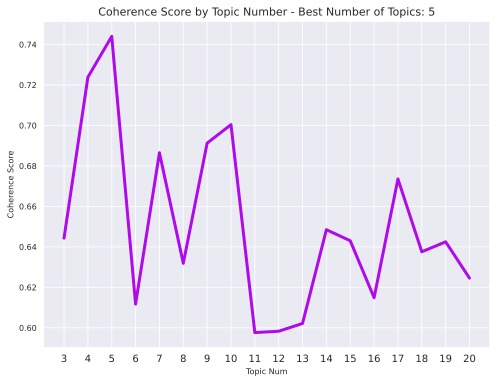

In [34]:

# Get the number of topics with the highest coherence score
from operator import itemgetter

# get the scores for each topic_num
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key = itemgetter(1), reverse = True)[0][0]

print(best_num_topics)

# Plot the results
fig = plt.figure(figsize=(8, 6))

sb.lineplot(
    x = topic_nums,
    y = coherence_scores,
    linewidth = 3,
    color = '#AE0AEB'
)

plt.xlabel("Topic Num", fontsize = 8)
plt.ylabel("Coherence Score", fontsize = 8)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize = 11)
plt.xticks(np.arange(3, max(topic_nums) + 1, 1), fontsize = 10)
plt.yticks(fontsize = 8)

plt.show()